# 목적
* 블로그 내용을 긁어와서 연관분석 진행
1. keyword관련 블로그 크롤링 
    정확도 기준으로 긁어오되 날짜도 같이 가져와서 나중 어떤 날짜에 집중되어 있는지 확인  
    한 블로그당 단어빈도수 분석(필요할까)
2. 블로그 내 단어 토크나이즈하고 
3. 연관분석실시


# 선행설치

In [1]:
#선행설치
# # 크롤링
# !pip install beautifulsoup4
# !pip install requests
# !pip install lxm
# # 연관분석
# !pip install apyori
# # 자연어처리
# !pip install konlpy (JDK 설치가 되어있어야함 )
# !pip install eunjeon
# # 워드클라우드
# !pip install wordcloud

In [2]:
# import
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook  # 진행과정 시각화
from datetime import timedelta  # 시간날짜
from apyori import apriori  # 연관분석

import re
import json
import math
import datetime
from datetime import timedelta
import pandas as pd

import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup  # 크롤링

import wordcloud
from PIL import Image
import random

import konlpy
from konlpy.tag import Komoran,Kkma,Okt,Twitter  # 자연어처리
from eunjeon import Mecab #은전한닢
mecab = Mecab()
komoran = Komoran(userdic='user_dictionary.txt')

#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

In [59]:
def del_outword(string):
    '''
    이모티콘, \u200b과 같은 문자가 아닌 것 제거
    #이모티콘 제거 [출처](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
    '''
    #이모지제거
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    #분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
    han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~"^_\n\r#\ufeff\u200d\u200b\u7643\ufffd\u682e\u62c4]+')
    
    string = emoji_pattern.sub(r'',string)
    string = han.sub(r'',string)
    
    return string

In [4]:
def time_change(x):
    '''
    검색결과에 있는 문자를 날짜로 변경
    '''
    min_pattern = re.compile('[0-9]+'+"분 전")
    hour_pattern = re.compile('[0-9]+'+"시간 전")
    day_pattern = re.compile('[0-9]+'+"일 전")

    today = datetime.datetime.today().date()
    # 일자
    try:
        d = re.findall(day_pattern, x)[0][0]
        x = today - timedelta(days=int(d))
    except:
        pass
    # 시간
    try:
        d = re.findall(hour_pattern, x)[0]
        x = today
    except:
        pass
    # 분
    try:
        h = re.findall(min_pattern, x)[0]
        x = today
    except:
        pass

    if x == '어제':
        x = today - timedelta(days=1)

    elif type(x) == str:
        x = datetime.datetime.strptime(x.replace('.', '-')[:-1], '%Y-%m-%d')
    #모든일자를 1일로 통일
    x = datetime.datetime.strptime(x.strftime('%Y-%m')+"-01","%Y-%m-%d")
    return x

In [5]:
def naver_blog_crawling(keyword, start_num=1, end_num=101, date_option=0, date_from='', date_to='', save=True):
    '''
    네이버 블로그 크롤링 함수
    네이버 블로그 검색결과를 크롤링하며, 1페이지당 10개씩을 검색한다

    keyword : string
     검색하고 싶은 키워드를 넣는다
     "keyword +필수어" 형태로 필수단어 추가 가능
    start_num : int (default = 1) 
     시작할 위치 1로 끝나는 단위 추천
    end_num : int (default = 101)
     끝나는 위치 1로 끝나는 단위 추천
    date_option : int (default = 0)
     주어지는 숫자에 의해 검색방법이 변경됨
     0 : 전체, 2 : 1일, 3 : 1주, 4 : 1개월, 6 : 6개월, 7 : 1년, 8 : 기간지정
    date_from : YYYYMMDD (default = "")
     date_option이 8일때 사용 검색 시작일자를 지정
    date_to : YYYMMDD (default = "")
     date_option이 8일때 사용 검색 마지막일자를 지정
    save : bool (default = True)
     csv로 저장 여부 결정
    '''
    # url 찾는 패턴
    pattern = re.compile('href="'+'[A-z0-9\:\/\&\;\.\?\=]+')

    # 저장위치
    postdates = []
    strings = []
    urls = []
    titles = []
    output_error = []
    connection_error = []
    count = 1

    # keyword와 시작넘버만 바꾸면서 진행하게끔
    base_url = 'https://search.naver.com/search.naver?date_from={date_from}&date_option={date_option}&date_to={date_to}&dup_remove=1&nso=&post_blogurl=&post_blogurl_without=&query={keyword}&sm=tab_pge&srchby=all&st=sim&where=post&start={start}'
    
    # for문 돌려야하는 부분(각 검색결과의 시작은 1이고, 10개씩 보여짐,)
    for i in tqdm_notebook(range(start_num, end_num+1, 10), desc="page work"):
        search_list = base_url.format(keyword=keyword, start=i,
                                      date_option=date_option, date_from=date_from, date_to=date_to)
        response = requests.get(search_list)

        if response.status_code is 200:
            # 1번 검색시 10개의 결과가 출력 따라서 section은 총 10개
            soup = BeautifulSoup(response.content, 'lxml')
            sections = soup.findAll('li', attrs={'class': 'sh_blog_top'})

            for section in sections:
                try:
                    # href부분만 가져오기 어려워서 정규표현식으로 검색
                    url = re.findall(pattern, str(section))[0].replace(
                        '?Redirect=Log&amp;logNo=', '/').replace('href="', '')
                    title = section.select_one('a.txt84').text
                    date = section.select_one('dd.txt_inline').text.strip()

                    # 블로그 url안에 들어가기(아직 크롤링불가)
                    get_blog_post_content_code = requests.get(url)
                    get_blog_post_content_text = get_blog_post_content_code.text
                    get_blog_post_content_soup = BeautifulSoup(
                        get_blog_post_content_text, 'lxml')

                    # 크롤링가능한 url에 접속
                    real_blog_post_url = "http://blog.naver.com" + \
                        get_blog_post_content_soup.select('#mainFrame')[
                            0].get('src')
                    get_real_blog_post_content_code = requests.get(
                        real_blog_post_url)
                    get_real_blog_post_content_text = get_real_blog_post_content_code.text
                    get_real_blog_post_content_soup = BeautifulSoup(
                        get_real_blog_post_content_text, 'lxml')

                    # url (에러나면 위에서부터 에러남)
                    urls.append(real_blog_post_url)
                    # 블로그명
                    titles.append(title)
                    # 날짜
                    postdates.append(date)

                    # 본문  (postviewarea 패턴과 se-main-container 2가지 유형이 있어 분리함)
                    try:
                        blog_post_content = get_real_blog_post_content_soup.select(
                            'div#postViewArea')
                        if len(blog_post_content) == 0:
                            blog_post_content = get_real_blog_post_content_soup.select(
                                'div.se-main-container')
                            if len(blog_post_content) == 0:
                                blog_post_content = get_real_blog_post_content_soup.select(
                                    'div.se_component_wrap.sect_dsc.__se_component_area')

                        string = ""
                        for sentence in blog_post_content[0].stripped_strings:
                            string += " "+sentence.replace('\xa0', " ")
                        # 비언어 텍스트제거
                        string = del_outword(string)
                        strings.append([string])
                        count += 1
                    except:
                        strings.append(["X"])
                        output_error.append(count)
                        count += 1

                except Exception as ex:
                    # print('가져오기에러 {num}번째'.format(num = count),ex)
                    output_error.append(count)
                    count += 1
                    pass
        else:
            # print('연결오류 {num}번째'.format(num = count),response.status_code)
            connection_error.append(count)
            count += 1

    out_length = len(output_error+connection_error)
    real_length = end_num-start_num+10-out_length
    print("검색한 길이:", end_num-start_num+10)
    print("제외된 길이:", out_length)
    print("검색된 길이:", real_length)
    crawling_df = pd.DataFrame(
        {"post_dates": postdates, "title": titles, "full_text": strings, "url": urls})
    crawling_df['post_dates'] = crawling_df['post_dates'].apply(
        lambda x: time_change(x))
    if save == True:
        today = datetime.datetime.today().date()
        str(today)
        crawling_df.to_csv("./output/"+str(today)+"_"+keyword+"_" +
                           str(real_length)+'.csv', encoding='utf-8')
    return crawling_df, real_length

In [62]:
def output_graph(tagger, dataframe, keyword, real_length, unique=True, save=True):
    # 날짜빈도분석
    plt.figure(figsize=(7, 5))
    plt.plot(dataframe['post_dates'].value_counts().sort_index())
    plt.xticks(rotation=45)
    if save == True:
        plt.savefig("./output/날짜빈도/"+str(today)+"_"+keyword +
                    "_"+str(real_length)+'_날짜빈도'+'.png')
    plt.show()

    # 단어빈도분석
    sw = list(set(['오늘', '시간', '최근', '지난', '관련', '이번', '이날', '현재', '10', '올해', '지난해', '있다', '이상', '기준', '때문',
              "메뉴", "주문", "강원도", '정도', '도착', '생각', '양양군', '사진', '위치', '라고', '양양', "아침", "저녁", '다음', '우리', '시작', '여기', '이곳', '사람']))
    sw.append(keyword.split(' ')[0])
    all_nouns = []

    for i in tqdm_notebook(range(0, len(dataframe))):
        nouns = tagger.nouns(dataframe['full_text'][i][0])
        clean_nouns = list(filter(lambda word: (
            len(word) > 1) & (word not in sw), nouns))
        if unique == True:
            clean_nouns = list(set(clean_nouns))
        all_nouns.append(clean_nouns)

    # 2중리스트 flatten
    all_noun_flatten = [y for x in all_nouns for y in x]

    count_df = pd.Series(all_noun_flatten).value_counts().reset_index()

    count_df.columns = ['word', 'counted']

    plt.figure(figsize=(7, 5))
    sns.barplot(x='word', y='counted', data=count_df.head(20))
    plt.xticks(rotation=45)
    if save == True:
        count_df.to_csv("./output/단어빈도_표/"+str(today)+"_"+keyword +
                        "_"+str(real_length)+'_단어빈도'+'.csv', encoding='cp949')
        plt.savefig("./output/단어빈도_그래프/"+str(today)+"_" +
                    keyword+"_"+str(real_length)+'_단어빈도'+'.png')
    plt.show()

    # 워드클라우드
    # 마스킹
    img_path = "vector-cloud-png.png"
    img = Image.open(img_path).convert('RGBA')
    mask = Image.new("RGB", img.size, (255, 255, 255))
    mask.paste(img, img)
    mask = np.array(mask)

    text = ' '.join(all_noun_flatten)

    wordc = wordcloud.WordCloud(background_color='White', max_words=200,
                                font_path='C:/Windows/Fonts/malgun.ttf',
                                relative_scaling=0.5,
                                stopwords=sw,
                                collocations=False,
                                mask=mask)
    wordc.generate(text)

    def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
        return 'hsl(%d,100%%,50%%)' % random.randint(200, 300)  # 색상 채도 밝기
    wordc.recolor(color_func=grey_color, random_state=3)

    # 그리기
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordc, interpolation='bilinear')
    # 저장
    if save == True:
        plt.savefig("./output/워드클라우드/"+str(today)+"_"+keyword +
                    "_"+str(real_length)+'_워드클라우드'+'.png')
    plt.show()

### 통합함수화

In [56]:
word_list = ["물치","전진","낙산","오산","수산","동호","하광정","기사문","동산","인구","광진","남애"]
mustword = "양양"
start_num = 1
end_num = 1201
date_option = 8
date_from = "20150101"
date_to = "20191231"
today = datetime.datetime.today().date()

In [60]:
def searching_all(word_list, mustword, start_num, end_num, date_option, date_from, date_to):
    for i in range(0,len(word_list)):
        keyword = word_list[i] + " +" + mustword
        print('{num}번째/{total_num}번째 {keyword}'.format(num = i+1, total_num = len(word_list),keyword = keyword))
        crawling_df, real_length = naver_blog_crawling(keyword, start_num, end_num, date_option, date_from, date_to)
        output_graph(mecab,crawling_df,keyword,real_length)
    return crawling_df

1번째/12번째 물치 +양양


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



검색한 길이: 1210
제외된 길이: 311
검색된 길이: 899


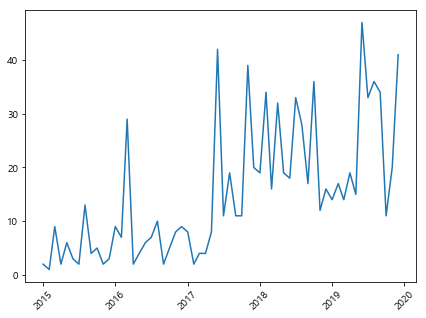

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


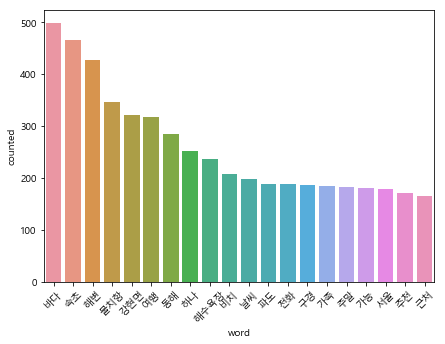

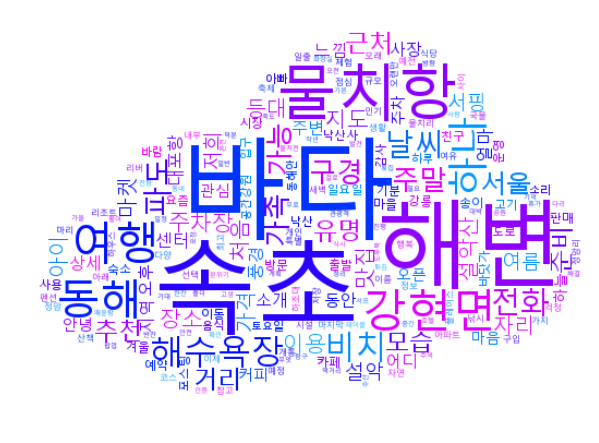

2번째/12번째 전진 +양양



검색한 길이: 1210
제외된 길이: 367
검색된 길이: 843


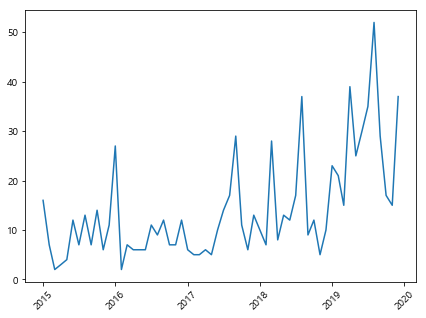

UnicodeEncodeError: 'cp949' codec can't encode character '\u62c4' in position 5: illegal multibyte sequence

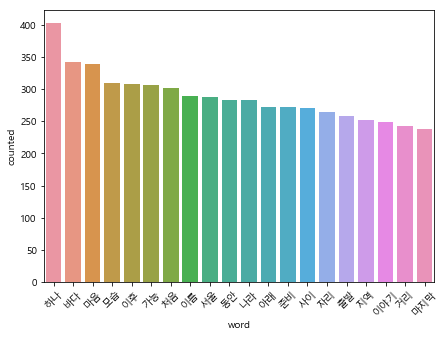

In [63]:
searching_all(word_list = word_list, mustword = mustword, start_num = start_num, end_num = end_num, date_option = date_option, date_from = date_from, date_to = date_to)